In [1]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
% matplotlib inline

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, ADASYN

from patsy import dmatrices
from sklearn import linear_model as lm
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, recall_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

Read in csv file downloaded from kaggle

In [2]:
df = pd.read_csv('police-department-incidents.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215024 entries, 0 to 2215023
Data columns (total 13 columns):
IncidntNum    int64
Category      object
Descript      object
DayOfWeek     object
Date          object
Time          object
PdDistrict    object
Resolution    object
Address       object
X             float64
Y             float64
Location      object
PdId          int64
dtypes: float64(2), int64(2), object(9)
memory usage: 219.7+ MB


In [3]:
df.drop_duplicates()
df.info()
# there are no duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215024 entries, 0 to 2215023
Data columns (total 13 columns):
IncidntNum    int64
Category      object
Descript      object
DayOfWeek     object
Date          object
Time          object
PdDistrict    object
Resolution    object
Address       object
X             float64
Y             float64
Location      object
PdId          int64
dtypes: float64(2), int64(2), object(9)
memory usage: 219.7+ MB


Find Nulls

In [4]:
df.isnull().values.any()

True

In [5]:
for i in df.columns:
    print(i, df[i].isnull().sum())
    
# there was only 1 row containing null

IncidntNum 0
Category 0
Descript 0
DayOfWeek 0
Date 0
Time 0
PdDistrict 1
Resolution 0
Address 0
X 0
Y 0
Location 0
PdId 0


In [6]:
df[df['PdDistrict'].isnull()]

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
1866038,166018573,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,2016-01-17T00:00:00,23:54,NaN,NONE,100 Block of VELASCO AV,-122.413352,37.708202,"{'latitude': '37.70820245849022', 'needs_recod...",16601857306244


In [7]:
df.drop(df.index[[1866038]],axis=0,inplace=True)

Dropped columns that would not be used in the modeling

In [8]:
df2 = df.drop(['IncidntNum', 'Descript', 'Address','X','Y','Location','PdId'], axis=1)

In [9]:
df.PdDistrict.value_counts()

SOUTHERN      399785
MISSION       300076
NORTHERN      272713
CENTRAL       226255
BAYVIEW       221000
INGLESIDE     194180
TENDERLOIN    191746
TARAVAL       166971
PARK          125479
RICHMOND      116818
Name: PdDistrict, dtype: int64

In [10]:
# import seaborn as sns
# case_by_district = df.PdDistrict.value_counts()


In [11]:
df.Category.value_counts()

LARCENY/THEFT                  480447
OTHER OFFENSES                 309358
NON-CRIMINAL                   238323
ASSAULT                        194694
VEHICLE THEFT                  126602
DRUG/NARCOTIC                  119628
VANDALISM                      116059
WARRANTS                       101379
BURGLARY                        91543
SUSPICIOUS OCC                  80444
MISSING PERSON                  64961
ROBBERY                         55867
FRAUD                           41542
SECONDARY CODES                 25831
FORGERY/COUNTERFEITING          23050
WEAPON LAWS                     22234
TRESPASS                        19449
PROSTITUTION                    16701
STOLEN PROPERTY                 11891
SEX OFFENSES, FORCIBLE          11742
DISORDERLY CONDUCT              10040
DRUNKENNESS                      9826
RECOVERED VEHICLE                8716
DRIVING UNDER THE INFLUENCE      5672
KIDNAPPING                       5346
RUNAWAY                          4440
LIQUOR LAWS 

In [12]:
crime_desc = df.Descript.value_counts()
crime_desc

GRAND THEFT FROM LOCKED AUTO                              178835
LOST PROPERTY                                              77956
BATTERY                                                    67654
STOLEN AUTOMOBILE                                          64763
DRIVERS LICENSE, SUSPENDED OR REVOKED                      62534
AIDED CASE, MENTAL DISTURBED                               56313
WARRANT ARREST                                             56230
SUSPICIOUS OCCURRENCE                                      52490
PETTY THEFT FROM LOCKED AUTO                               51946
PETTY THEFT OF PROPERTY                                    46114
MALICIOUS MISCHIEF, VANDALISM                              45238
MALICIOUS MISCHIEF, VANDALISM OF VEHICLES                  44290
TRAFFIC VIOLATION                                          38105
THREATS AGAINST LIFE                                       34670
FOUND PROPERTY                                             33383
GRAND THEFT OF PROPERTY  

In [13]:
# import csv
# header = ['Description', 'Count']
# with open('crime_classes.csv','w') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(header)

In [14]:
# with open('crime_classes.csv', 'a') as csvfile:
#     writer = csv.writer(csvfile)
#     for line in crime_desc.iteritems():
#         print(line[0])
#         print(line[1])
#         writer.writerow([line[0],line[1]])
# # remember to wrap inside the list or else the writerow will break up the description by character

Load in dataframe with crime description and corresponding crime level (1 and 3), which was determined based on best judgement given the limited crime descriptions provided in this dataset. Please note Class 2 has been absorbed into Class 1. 

In [15]:
# load in dataframe
crime_class_df = pd.read_csv('crime_classes_v2.csv')
crime_class_df.info()
crime_class_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 3 columns):
Description    914 non-null object
Count          914 non-null int64
class          914 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.5+ KB


,Description,Count,class
0,"AGGRAVATED ASSAULT OF POLICE OFFICER, SNIPING",2,1
1,"AGGRAVATED ASSAULT OF POLICE OFFICER,BODILY FORCE",391,1
2,AGGRAVATED ASSAULT ON POLICE OFFICER WITH A GUN,15,1
3,AGGRAVATED ASSAULT ON POLICE OFFICER WITH A KNIFE,56,1
4,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,16405,1


In [16]:
crime_class_df = crime_class_df.drop('Count',axis=1)

In [17]:
desc_dict = crime_class_df.set_index('Description').to_dict()
new_dict = desc_dict['class']

In [18]:
len(new_dict)

914

Create new column, "crime_level"

In [19]:
df['crime_level'] = df.Descript.map(new_dict)

Checked to see if there is any null values. There was only one description that were missing the crime level values, that happens to be a class 3 crime level.

In [20]:
# nulldf = df[df['crime_level'].isnull()]
# nulldf.shape
# nulldf.crime_level.value_counts()
# df[df['Descript']== 'GRAND THEFT FROM LOCKED AUTO'].fillna(3,inplace=True)

In [21]:
df.crime_level.fillna(3,inplace=True)

In [22]:
df[df['Descript']== 'GRAND THEFT FROM LOCKED AUTO']
# df[df['Descript'] == 'GRAND THEFT FROM LOCKED AUTO']
# nulldf2 = df[df['crime_level'].isnull()]
# nulldf2

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,crime_level
10,60027038,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Saturday,2006-01-07T00:00:00,22:00,NORTHERN,NONE,100 Block of HEMLOCK ST,-122.420815,37.787236,"{'latitude': '37.7872360476925', 'needs_recodi...",6002703806244,3.0
16,96043222,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,2009-06-16T00:00:00,22:00,TARAVAL,NONE,1600 Block of GREAT HWY,-122.508797,37.756259,"{'latitude': '37.7562590463517', 'needs_recodi...",9604322206244,3.0
17,60435237,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,2006-04-23T00:00:00,21:00,INGLESIDE,NONE,TIFFANY AV / DUNCAN ST,-122.420132,37.746575,"{'latitude': '37.7465750465073', 'needs_recodi...",6043523706244,3.0
19,106159858,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,2010-12-15T00:00:00,17:45,RICHMOND,NONE,1000 Block of POINTLOBOS AV,-122.513642,37.778469,"{'latitude': '37.7784692199467', 'needs_recodi...",10615985806244,3.0
27,40432708,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Thursday,2004-04-15T00:00:00,15:00,SOUTHERN,NONE,900 Block of BRYANT ST,-122.406730,37.772637,"{'latitude': '37.7726367624181', 'needs_recodi...",4043270806244,3.0
58,66088640,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,2006-12-06T00:00:00,00:05,SOUTHERN,NONE,WASHBURN ST / MISSION ST,-122.415131,37.775889,"{'latitude': '37.7758891459127', 'needs_recodi...",6608864006244,3.0
91,86004739,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Thursday,2008-01-17T00:00:00,01:40,SOUTHERN,NONE,HOWARD ST / 2ND ST,-122.398262,37.786779,"{'latitude': '37.7867787589097', 'needs_recodi...",8600473906244,3.0
105,60031534,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,2006-01-04T00:00:00,18:30,SOUTHERN,NONE,300 Block of SPEAR ST,-122.390136,37.789481,"{'latitude': '37.7894806825431', 'needs_recodi...",6003153406244,3.0
120,70767638,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,2007-07-29T00:00:00,12:30,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,"{'latitude': '37.775420706711', 'needs_recodin...",7076763806244,3.0
141,106072608,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Saturday,2010-06-12T00:00:00,13:30,SOUTHERN,NONE,SPEAR ST / MISSION ST,-122.394065,37.792538,"{'latitude': '37.792537817505', 'needs_recodin...",10607260806244,3.0


Create new column for "Time of Day", in 6 hour intervals

In [23]:
df['morning'] = np.where((df.Time >= '06:00') & (df.Time <'12:00'), 1, 0)
df['afternoon'] = np.where((df.Time >= '12:00') & (df.Time <'18:00'), 1, 0)
df['night'] = np.where((df.Time >= '18:00') & (df.Time <'24:00'), 1, 0)
df['late_night'] = np.where((df.Time >= '00:00') & (df.Time <'06:00'), 1, 0)

In [24]:
# drop columns that will not be used in modeling
df2 = df.drop(['IncidntNum', 'Category', 'Resolution', 'Descript', 'Date', 'Time', 'Address', 'X', 'Y', 'Location','PdId'], axis=1)

Turn "DayOfWeek" and "PdDistrict" into Categorical Features using get_dummies 

In [25]:
df3 = pd.get_dummies(df2.DayOfWeek,drop_first=True)
df4 = pd.get_dummies(df2.PdDistrict,drop_first=True)
df5 = pd.concat([df2, df3, df4], axis=1)
df5 = df5.drop(['DayOfWeek', 'PdDistrict'], axis=1)

Column Keys:

**Crime Levels:**(Target)  
Level 1 - Serious,Violent,Priority OR Potential to Escalate  
Level 3 - Non-Violent, Low Priority


Features(Categorical):

**Time of Day:**  
Morning - 6am to 12pm  
Afternoon - 12pm to 6pm  
Night - 6pm to 12AM  
Late Night - 12 AM to 6AM

**Day of Week**  
Monday, Tuesday, Wednesday, Thursday, Friday, Saturday,Sunday

**Police Districts**  
SOUTHERN     
MISSION       
NORTHERN      
CENTRAL       
BAYVIEW       
INGLESIDE     
TENDERLOIN    
TARAVAL       
PARK         
RICHMOND

CREATED SUBSET/HOLDOUT SET. Checked to see that the different classes were split up evenly 

In [26]:
np.random.seed(16)
df_index = df5.index.unique()
index_subset = np.random.choice(df_index, size = int(df_index.shape[0]*.5), replace = False)

df_subset = df5[df5.index.isin(index_subset)]
df_holdout = df5[np.logical_not(df5.index.isin(index_subset))]

In [27]:
df_subset.crime_level.value_counts()

3.0    826402
1.0    281109
Name: crime_level, dtype: int64

In [28]:
df_holdout.crime_level.value_counts()

3.0    825465
1.0    282047
Name: crime_level, dtype: int64

In [29]:
y_sub = df_subset.crime_level

In [30]:
X_sub = df_subset.drop('crime_level', axis=1)

In [31]:
# holdout set X & Y
y_holdout = df_holdout.crime_level
X_holdout = df_holdout.drop('crime_level', axis=1)

Run SMOTE and ADASYN to resample data to account for class imbalance. Previous modeling without applying SMOTE or ADASYN yielded worst results. Adjusting sample weight in the various models alone, without using SMOTE/ADASYN did not improve the results much. 

In [33]:
# ada = ADASYN(random_state=56,n_jobs=-1)
# X_res, y_res = ada.fit_resample(X_sub, y_sub)

In [34]:
sm = SMOTE(random_state=26, n_jobs=-1)
X_res, y_res = sm.fit_resample(X_sub, y_sub)

In [126]:
y_ho = df_holdout.crime_level
X_ho = df_holdout.drop('crime_level', axis=1)

In [35]:
# import pickle

# with open('AdaXY.pkl', 'wb') as file:
#     pickle.dump([X_res, y_res], file)
#     file.close()

In [36]:
# with open('AdaXY.pkl', 'rb') as file:
#     X_Ada, Y_Ada = pickle.load(file)
#     file.close()
    
# # print(f'this is foo {foo}, this is bar {bar}')
# # remember to turn this back into a dataframe if applicable

In [37]:
# X_res = X_Ada
# y_res = Y_Ada

Applied train_test_split with 20% test size

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.2, random_state=36)

The first model used was logistic regression, however, due to there being 3 classes, it was hard to get good interpretability. Code for logistic regression is at the bottom of this notebook. 

Second model applied was Naive Bayes (Gaussian, Bernouli, Multinomial). See below

In [41]:
# Gaussian NB with class_weight='balanced' set

from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight

# Standardize Data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.transform(X_test)

model_GNB = naive_bayes.GaussianNB()
model_GNB.fit(X_tr, Y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=Y_train))

print("Accuracy: %.3f"% accuracy_score(Y_test, model_GNB.predict(X_te)))
print(classification_report(Y_test, model_GNB.predict(X_te)))

Accuracy: 0.539
              precision    recall  f1-score   support

         1.0       0.54      0.58      0.56    165280
         3.0       0.54      0.50      0.52    165281

   micro avg       0.54      0.54      0.54    330561
   macro avg       0.54      0.54      0.54    330561
weighted avg       0.54      0.54      0.54    330561



In [145]:
# Testing on HOLDOUT SET - Gaussian NB
model_GNB.predict(X_ho)
model_GNB.score(X_ho,y_ho)
print("Accuracy: %.3f"% accuracy_score(y_ho, model_GNB.predict(X_ho)))
print(classification_report(y_ho, model_GNB.predict(X_ho)))

Accuracy: 0.346
              precision    recall  f1-score   support

         1.0       0.26      0.88      0.41    282047
         3.0       0.79      0.17      0.27    825465

   micro avg       0.35      0.35      0.35   1107512
   macro avg       0.53      0.52      0.34   1107512
weighted avg       0.66      0.35      0.31   1107512



In [46]:
# Gaussian NB with class_weight arbitrarily set

# Standardize Data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.transform(X_test)

model_GNB = naive_bayes.GaussianNB()
model_GNB.fit(X_tr, Y_train, sample_weight=compute_sample_weight(class_weight={1:3, 3:1}, y=Y_train))

print("Accuracy: %.3f"% accuracy_score(Y_test, model_GNB.predict(X_te)))
print(classification_report(Y_test, model_GNB.predict(X_te)))

Accuracy: 0.521
              precision    recall  f1-score   support

         1.0       0.51      0.87      0.65    165280
         3.0       0.57      0.17      0.26    165281

   micro avg       0.52      0.52      0.52    330561
   macro avg       0.54      0.52      0.45    330561
weighted avg       0.54      0.52      0.45    330561



In [43]:
#Bernouli NB

# Standardize Data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.transform(X_test)

model_BNB = naive_bayes.BernoulliNB(fit_prior=False)
model_BNB.fit(X_tr, Y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=Y_train))

print("Accuracy: %.3f"% accuracy_score(Y_test, model_BNB.predict(X_te)))
print(classification_report(Y_test, model_BNB.predict(X_te)))

Accuracy: 0.541
              precision    recall  f1-score   support

         1.0       0.55      0.47      0.50    165280
         3.0       0.54      0.61      0.57    165281

   micro avg       0.54      0.54      0.54    330561
   macro avg       0.54      0.54      0.54    330561
weighted avg       0.54      0.54      0.54    330561



In [44]:
# Multinomial will not take in negative input. If you standardize, the inputs may turn negative

model_MNB = naive_bayes.MultinomialNB()
model_MNB.fit(X_train, Y_train,sample_weight=compute_sample_weight(class_weight='balanced', y=Y_train))

print("Accuracy: %.3f"% accuracy_score(Y_test, model_MNB.predict(X_test)))
print(classification_report(Y_test, model_MNB.predict(X_test)))

Accuracy: 0.541
              precision    recall  f1-score   support

         1.0       0.55      0.47      0.50    165280
         3.0       0.54      0.62      0.57    165281

   micro avg       0.54      0.54      0.54    330561
   macro avg       0.54      0.54      0.54    330561
weighted avg       0.54      0.54      0.54    330561



Decision Tree & Random Forest

In [47]:
from sklearn.tree import DecisionTreeClassifier

# Standardize Data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.transform(X_test)

dtmodel = DecisionTreeClassifier()
dtmodel.fit(X_tr, Y_train)
dtscore = dtmodel.score(X_tr, Y_train) 

print(dtscore)
print("Accuracy: %.3f"% accuracy_score(Y_train, dtmodel.predict(X_tr)))
print(classification_report(Y_train, dtmodel.predict(X_tr)))

0.5475566896553811
Accuracy: 0.548
              precision    recall  f1-score   support

         1.0       0.55      0.54      0.54    661122
         3.0       0.55      0.56      0.55    661121

   micro avg       0.55      0.55      0.55   1322243
   macro avg       0.55      0.55      0.55   1322243
weighted avg       0.55      0.55      0.55   1322243



In [143]:
# Testing on HOLDOUT SET - Dec. Tree
dtmodel.predict(X_ho)
dtmodel.score(X_ho,y_ho)
print("Accuracy: %.3f"% accuracy_score(y_ho, dtmodel.predict(X_ho)))
print(classification_report(y_ho, dtmodel.predict(X_ho)))

Accuracy: 0.255
              precision    recall  f1-score   support

         1.0       0.25      1.00      0.41    282047
         3.0       0.00      0.00      0.00    825465

   micro avg       0.25      0.25      0.25   1107512
   macro avg       0.13      0.50      0.20   1107512
weighted avg       0.06      0.25      0.10   1107512



In [55]:
# Decision Tree Classifier with class_weight arbitrarily set
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier(class_weight={1:2, 3:1})
dtmodel.fit(X_tr, Y_train)
dtscore = dtmodel.score(X_tr, Y_train) 

print(dtscore)
print("Accuracy: %.3f"% accuracy_score(Y_test, dtmodel.predict(X_te)))
print(classification_report(Y_test, dtmodel.predict(X_te)))

0.5000003781453182
Accuracy: 0.500
              precision    recall  f1-score   support

         1.0       0.50      1.00      0.67    165280
         3.0       0.00      0.00      0.00    165281

   micro avg       0.50      0.50      0.50    330561
   macro avg       0.25      0.50      0.33    330561
weighted avg       0.25      0.50      0.33    330561



In [51]:
# Decision Tree Classifier with class_weight set to balanced
from sklearn.tree import DecisionTreeClassifier

dtmodel = DecisionTreeClassifier(class_weight='balanced')
dtmodel.fit(X_tr, Y_train)
dtscore = dtmodel.score(X_tr, Y_train) 

print(dtscore)
print("Accuracy: %.3f"% accuracy_score(Y_test, dtmodel.predict(X_te)))
print(classification_report(Y_test, dtmodel.predict(X_te)))

0.5475566896553811
Accuracy: 0.547
              precision    recall  f1-score   support

         1.0       0.55      0.54      0.54    165280
         3.0       0.55      0.56      0.55    165281

   micro avg       0.55      0.55      0.55    330561
   macro avg       0.55      0.55      0.55    330561
weighted avg       0.55      0.55      0.55    330561



Below are several Models using Random Forest Classifier with varying parameters

In [52]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators = 750,
                                min_samples_leaf = 20, n_jobs=-1)
rfmodel.fit(X_tr, Y_train)

print("Accuracy: %.3f"% accuracy_score(Y_test, rfmodel.predict(X_te)))
print(classification_report(Y_test, rfmodel.predict(X_te)))

Accuracy: 0.547
              precision    recall  f1-score   support

         1.0       0.55      0.54      0.54    165280
         3.0       0.55      0.56      0.55    165281

   micro avg       0.55      0.55      0.55    330561
   macro avg       0.55      0.55      0.55    330561
weighted avg       0.55      0.55      0.55    330561



In [140]:
# Testing on HOLDOUT SET - Random Forest
rfmodel.predict(X_ho)
rfmodel.score(X_ho,y_ho)
print("Accuracy: %.3f"% accuracy_score(y_ho, rfmodel.predict(X_ho)))
print(classification_report(y_ho, rfmodel.predict(X_ho)))

Accuracy: 0.552
              precision    recall  f1-score   support

         1.0       0.29      0.53      0.38    282047
         3.0       0.78      0.56      0.65    825465

   micro avg       0.55      0.55      0.55   1107512
   macro avg       0.54      0.55      0.51   1107512
weighted avg       0.65      0.55      0.58   1107512



Text(0,0.5,'TPR')

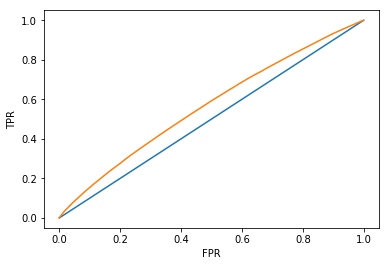

In [141]:
y_hoscore=rfmodel.predict_proba(X_ho)[:, 0]

fpr, tpr,_ = roc_curve(y_ho, y_hoscore, pos_label=1.0)
roc_auc = auc(fpr, tpr)

name = 'ROC Curve - Log. Reg.'
plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr, tpr, label='area = {0}'.format(roc_auc))
# plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
# plt.title("ROC Curve - Log. Reg. ")

In [142]:
roc_auc

0.566187883825757

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators = 750,
                                min_samples_leaf = 10, n_jobs=-1)
rfmodel.fit(X_train, Y_train)

print("Accuracy: %.3f"% accuracy_score(Y_test, rfmodel.predict(X_test)))
print(classification_report(Y_test, rfmodel.predict(X_test)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators = 750,
                                min_samples_leaf = 30, n_jobs=-1)
rfmodel.fit(X_train, Y_train)

print("Accuracy: %.3f"% accuracy_score(Y_test, rfmodel.predict(X_test)))
print(classification_report(Y_test, rfmodel.predict(X_test)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators = 1000,
                                min_samples_leaf = 20, n_jobs=-1)
rfmodel.fit(X_train, Y_train)

print("Accuracy: %.3f"% accuracy_score(Y_test, rfmodel.predict(X_test)))
print(classification_report(Y_test, rfmodel.predict(X_test)))

AdaBoost Classifier

In [53]:
from sklearn.ensemble import AdaBoostClassifier

abmodel = AdaBoostClassifier(random_state=66)
abmodel.fit(X_tr, Y_train)

print("Accuracy: %.3f"% accuracy_score(Y_test, abmodel.predict(X_te)))
print(classification_report(Y_test, abmodel.predict(X_te)))

Accuracy: 0.542
              precision    recall  f1-score   support

         1.0       0.54      0.52      0.53    165280
         3.0       0.54      0.56      0.55    165281

   micro avg       0.54      0.54      0.54    330561
   macro avg       0.54      0.54      0.54    330561
weighted avg       0.54      0.54      0.54    330561



In [146]:
# Testing on HOLDOUT SET - Adaboost
abmodel.predict(X_ho)
abmodel.score(X_ho,y_ho)
print("Accuracy: %.3f"% accuracy_score(y_ho, abmodel.predict(X_ho)))
print(classification_report(y_ho, abmodel.predict(X_ho)))

Accuracy: 0.553
              precision    recall  f1-score   support

         1.0       0.29      0.52      0.37    282047
         3.0       0.77      0.56      0.65    825465

   micro avg       0.55      0.55      0.55   1107512
   macro avg       0.53      0.54      0.51   1107512
weighted avg       0.65      0.55      0.58   1107512



0.5625485126991279

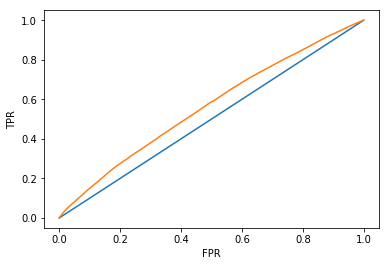

In [147]:
y_hoscore=abmodel.predict_proba(X_ho)[:, 0]

fpr, tpr,_ = roc_curve(y_ho, y_hoscore, pos_label=1.0)
roc_auc = auc(fpr, tpr)


plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr, tpr, label='area = {0}'.format(roc_auc))
# plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

roc_auc

In [59]:
#Logistic Regression

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, stratify=y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    scaler = StandardScaler()
    xtrain = scaler.fit_transform(xtrain)
    xtest = scaler.transform(xtest)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

Training Data Accuracy: 0.54
Test Data Accuracy:     0.54
[[86227 79053]
 [71516 93765]]


Precision:              0.55
Recall:                 0.52


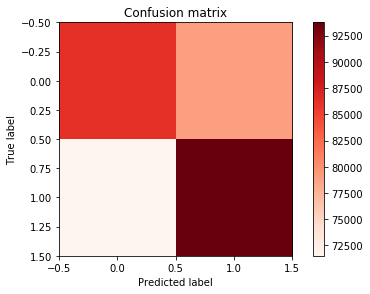

In [60]:
log_clf=LogisticRegression()
train_score(log_clf,X_res,y_res)

In [95]:
log.predict_proba(xtest)

array([[0.51668645, 0.48331355],
       [0.391758  , 0.608242  ],
       [0.42696377, 0.57303623],
       ...,
       [0.58163908, 0.41836092],
       [0.58163908, 0.41836092],
       [0.44953783, 0.55046217]])

Text(0,0.5,'TPR')

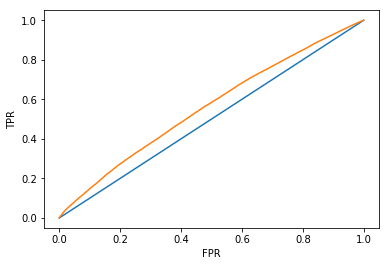

In [114]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# xtrain, xtest, ytrain, ytest = train_test_split(X_res, y_res, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:, 0]

fpr, tpr,_ = roc_curve(ytest, y_score, pos_label=1.0)
roc_auc = auc(fpr, tpr)

name = 'ROC Curve - Log. Reg.'
plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr, tpr, label='area = {0}'.format(roc_auc))
# plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
# plt.title("ROC Curve - Log. Reg. ") 

In [98]:
roc_auc

0.5606851958219662

In [136]:
# Testing HOLDOUT SET
log_clf.predict(X_ho)
log_clf.score(X_ho,y_ho)
print("Accuracy: %.3f"% accuracy_score(y_ho, log_clf.predict(X_ho)))
print(classification_report(y_ho, log_clf.predict(X_ho)))

Accuracy: 0.539
              precision    recall  f1-score   support

         1.0       0.29      0.55      0.38    282047
         3.0       0.78      0.53      0.63    825465

   micro avg       0.54      0.54      0.54   1107512
   macro avg       0.53      0.54      0.51   1107512
weighted avg       0.65      0.54      0.57   1107512



Text(0,0.5,'TPR')

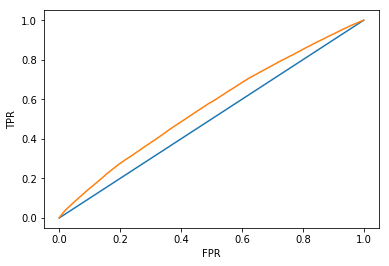

In [139]:
y_hoscore=log_clf.predict_proba(X_ho)[:, 0]

fpr, tpr,_ = roc_curve(y_ho, y_hoscore, pos_label=1.0)
roc_auc = auc(fpr, tpr)

name = 'ROC Curve - Log. Reg.'
plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr, tpr, label='area = {0}'.format(roc_auc))
# plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
# plt.title("ROC Curve - Log. Reg. ")

Ignore below section

array([0.48331355, 0.608242  , 0.57303623, ..., 0.41836092, 0.41836092,
       0.55046217])

In [77]:
log.predict_proba(xtest)

array([[0.51668645, 0.48331355],
       [0.391758  , 0.608242  ],
       [0.42696377, 0.57303623],
       ...,
       [0.58163908, 0.41836092],
       [0.58163908, 0.41836092],
       [0.44953783, 0.55046217]])

In [79]:
print(classification_report(ytest, log.predict(xtest), ))

              precision    recall  f1-score   support

         1.0       0.54      0.51      0.53    165171
         3.0       0.54      0.57      0.56    165390

   micro avg       0.54      0.54      0.54    330561
   macro avg       0.54      0.54      0.54    330561
weighted avg       0.54      0.54      0.54    330561



In [84]:
log.predict(xtest)

array([1., 3., 3., ..., 1., 1., 3.])

In [91]:
preds = [0 if pred == 3.0 else 1 for pred in log.predict(xtest)]
y_test = [0 if pred == 3.0 else 1 for pred in ytest]

In [92]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.54      0.57      0.56    165390
           1       0.54      0.51      0.53    165171

   micro avg       0.54      0.54      0.54    330561
   macro avg       0.54      0.54      0.54    330561
weighted avg       0.54      0.54      0.54    330561



In [ ]:
def plot_roc(name, clf, y_test, X_test):
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= 'area = {}'.format(roc_auc)) 
#     plt.plot(fpr, tpr, label=‘%s (area = %0.3f)’ % (name, roc_auc))
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    #plt.savefig(‘Log_ROC’)
    plt.show()
    return fpr, tpr, thresholds